In [ ]:
# Necessary installments for pandas_ta library to work...

!pip uninstall numpy -y
!pip install numpy==1.26.4  # Downgrade to a stable version
!pip uninstall pandas_ta -y
!pip install pandas_ta --no-cache-dir

# RESTART RUNTIME (ΠΕΡΙΟΔΟΣ ΛΕΙΤΟΥΡΓΙΑΣ) AFTER PANDAS_TA IS INSTALLED AND THEN RUN THE REST OF THE CELLS

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 364.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=b37f2c6d17a74606cef933cbd2cca8203daf4334b7ba2a5236bcdc309a5fc96a
  Stored in directory: /tmp/pip-ephem-wheel-cache-y_5rmgen/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
# 1. Read, clean the data and calculate btc volatility & technical indicators


# Download Fear and Greed Index data
url = 'https://api.alternative.me/fng/?limit=0&format=json'
response = requests.get(url)
data = response.json()

# Parse the data
fear_greed = pd.DataFrame(data['data'])
fear_greed['timestamp'] = pd.to_datetime(fear_greed['timestamp'].astype(int), unit='s').dt.date
fear_greed.set_index('timestamp', inplace=True)
fear_greed['value'] = fear_greed['value'].astype(int)
fear_greed = fear_greed[['value']]
fear_greed.columns = ['FearGreedIndex']
fear_greed = fear_greed.rename_axis('Date')

# Clean the data
btc = pd.read_csv('/BTC-USD.csv', thousands = ',')[['Date','Price','Vol.']]
sp500 = pd.read_csv('/S&P 500.csv', thousands = ',')[['Date','Price']]
nasdaq = pd.read_csv('/NASDAQ.csv', thousands = ',')[['Date','Price']]
gold = pd.read_csv('/GOLD.csv', thousands = ',')[['Date','Price']]
dxy = pd.read_csv('/DXY.csv', thousands = ',')[['Date','Price']]
tnx = pd.read_csv('/TNX.csv', thousands = ',')[['Date','Price']]
vix = pd.read_csv('/VIX.csv', thousands = ',')[['Date','Price']]

btc['Vol.'] = btc['Vol.'].str.replace('K','').astype(float)
btc['Vol.'] = btc['Vol.']*1000

# Convert the date to datetime
btc['Date'] =  pd.to_datetime(btc['Date']).dt.date
sp500['Date'] =  pd.to_datetime(sp500['Date']).dt.date
nasdaq['Date'] =  pd.to_datetime(nasdaq['Date']).dt.date
gold['Date'] =  pd.to_datetime(gold['Date']).dt.date
dxy['Date'] =  pd.to_datetime(dxy['Date']).dt.date
tnx['Date'] =  pd.to_datetime(tnx['Date']).dt.date
vix['Date'] =  pd.to_datetime(vix['Date']).dt.date


# Set 'Date' as the index
btc.set_index('Date', inplace=True)
sp500.set_index('Date', inplace=True)
nasdaq.set_index('Date', inplace=True)
gold.set_index('Date', inplace=True)
dxy.set_index('Date', inplace=True)
tnx.set_index('Date', inplace=True)
vix.set_index('Date', inplace=True)

# Rename columns
btc.rename(columns={'Price': 'BTC', 'Vol.': 'Volume'},inplace=True)
sp500.rename(columns={'Price': 'SP500'},inplace=True)
nasdaq.rename(columns={'Price': 'NASDAQ'},inplace=True)
gold.rename(columns={'Price': 'GOLD'},inplace=True)
dxy.rename(columns={'Price': 'DXY'},inplace=True)
tnx.rename(columns={'Price': 'TNX'},inplace=True)
vix.rename(columns={'Price': 'VIX'},inplace=True)


# Start with the first DataFrame (btc) and merge the others on 'Date'
og_data = pd.merge(btc, sp500, on='Date', how='left')  # 'inner' keeps only matching dates
og_data = pd.merge(og_data, nasdaq, on='Date', how='left')
og_data = pd.merge(og_data, gold, on='Date', how='left')
og_data = pd.merge(og_data, dxy, on='Date', how='left')
og_data = pd.merge(og_data, tnx, on='Date', how='left')
og_data = pd.merge(og_data, vix, on='Date', how='left')
og_data = pd.merge(og_data, fear_greed, on='Date', how='left')

# Sort by date
og_data = og_data.sort_values(by="Date", ascending = True)

# First calculate daily returns
og_data['BTC_Volatility'] = og_data['BTC'].pct_change(fill_method=None).rolling(window=14).std()

#Calculate RSI
og_data["RSI"] = ta.rsi(og_data["BTC"], length=14)

#Calculate SMAs
og_data["SMA_50"] = ta.sma(og_data["BTC"], length=50)
og_data["SMA_100"] = ta.sma(og_data["BTC"], length=100)
og_data["SMA_200"] = ta.sma(og_data["BTC"], length=200)

#Calculate Bollinger Bands
bbands = ta.bbands(og_data["BTC"], length=20, std=2)
og_data["BB_upper"] = bbands["BBU_20_2.0"]
og_data["BB_middle"] = bbands["BBM_20_2.0"]
og_data["BB_lower"] = bbands["BBL_20_2.0"]




In [ ]:
og_data

,BTC,Volume,SP500,NASDAQ,GOLD,DXY,TNX,VIX,FearGreedIndex,BTC_Volatility,RSI,SMA_50,SMA_100,SMA_200,BB_upper,BB_middle,BB_lower
Date,,,,,,,,,,,,,,,,,
2017-01-01,999.0,13440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1019.3,21820.0,NaN,NaN,NaN,102.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1037.5,14110.0,2257.80,4911.33,1162.00,103.21,24.50,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,1139.6,53730.0,2270.80,4937.20,1165.30,102.70,24.52,11.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1003.2,91200.0,2269.00,4964.95,1181.30,101.52,23.68,11.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,93784.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,61.0,0.019380,66.159662,84883.00,90737.33,89259.570,97236.347403,86682.50,76128.652597
2025-04-28,95046.0,1340.0,5528.75,19427.29,3347.70,99.01,42.16,25.15,54.0,0.019423,68.288307,85166.06,90642.89,89433.115,97640.406017,87618.20,77595.993983
2025-04-29,94451.0,500.0,5560.83,19544.95,3347.60,99.24,41.73,24.17,60.0,0.019143,66.174801,85480.40,90573.80,89592.465,98372.894091,88213.65,78054.405909


In [ ]:
# 2. Train test on shuffled 80,20 data and evaluate

og_data['BTC_Tomorrow'] = og_data['BTC'].shift(-1)

# Drop NaN values so we test our data (and save it to a new df because the last row will be deleted)
og_data2 = og_data.dropna()

X = og_data2[['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']] # Independent variables
y = og_data2['BTC_Tomorrow'] # Dependent variable

# Splitting data into training and test sets (80% - 20%)
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Model predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Show results
print("MSE:", mse)
print(f"R²: {r2*100:.4f} %")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape*100:.4f}%")  # Display MAPE as a percentage

# Show variable (coefficients) of the model
print("Coefficients:", model.coef_)

# Show intercept and slope
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])

MSE: 4751235.8750412045
R²: 99.3130 %
RMSE: 2179.7329825098313
MAPE: 10.3946%
Coefficients: [ 6.57641150e-03 -1.94317070e+00  2.39280653e-01  1.20040573e+00
 -2.95225335e+01  3.94026479e+01 -2.42309378e+01  1.75678570e+01
 -1.30472430e+04  1.34905001e+02 -1.02751185e-02 -1.61122655e-01
  1.64417834e-01  5.04855921e-01  3.35997715e-01  1.67137204e-01]
Intercept: -3200.003428460379
Slope: 0.006576411500853204


Number of observations that the model predicted: 362


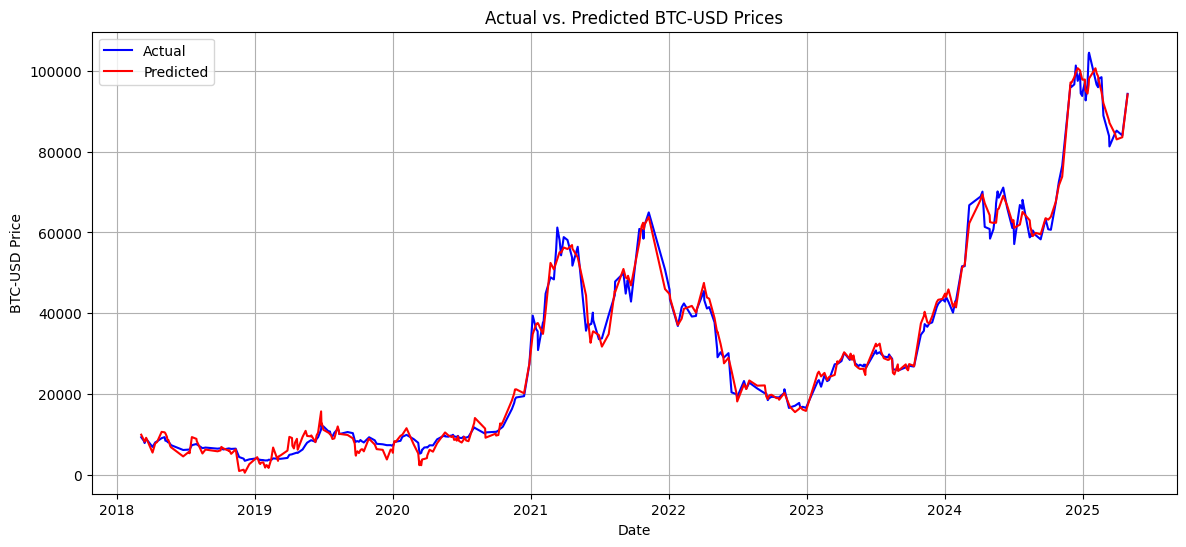

In [ ]:
# 4 Visualize the predictions on 20% of the observations (shuffled data)

og_data_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Sort by Date (oldest to newest)
og_data_test.sort_index(ascending=True, inplace=True)

print('Number of observations that the model predicted:',len(og_data_test))

plt.figure(figsize=(14, 6))
plt.plot( og_data_test['Actual'], label='Actual', color='blue')
plt.plot(og_data_test['Predicted'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('BTC-USD Price')
plt.title('Actual vs. Predicted BTC-USD Prices')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 5. Train test on continuous 80,20 data and evaluate

X2 = og_data2[['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']] # Independent variables
y2 = og_data2['BTC_Tomorrow'] # Dependent variable


# Calculate the split index
split_index = int(len(og_data2) * 0.8)  # 80% of the data

# Split the data into training and testing sets
X_train2 = og_data2.iloc[:split_index][['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']]
y_train2 = og_data2.iloc[:split_index]['BTC_Tomorrow']

X_test2 = og_data2.iloc[split_index:][['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']]
y_test2 = og_data2.iloc[split_index:]['BTC_Tomorrow']

# Model training and evaluation remain the same
model = LinearRegression()
model.fit(X_train2, y_train2)

y_pred2 = model.predict(X_test2)

# Model evaluation
mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test2, y_pred2)
rmse2 = np.sqrt(mse)
mape2 = mean_absolute_percentage_error(y_test2, y_pred2)

# Show results
print("Mean Squared Error:", mse2)
print("R²:", r22)
print(f"RMSE: {rmse2}")
print(f"MAPE: {mape2*100:.4f}%")  # Display MAPE as a percentage

# Show variable (coefficients) of the model
print("Coefficients:", model.coef_)

# Show intercept and slope
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])


Mean Squared Error: 16068529.369658392
R²: 0.9568741168660424
RMSE: 2179.7329825098313
MAPE: 4.0553%
Coefficients: [-4.75967374e-03 -7.11724968e-01  4.55911197e-01 -2.46453564e+00
 -4.68037007e+01  2.10000153e+01  1.92889588e+01  1.03442335e+01
 -5.16795705e+03  1.10202685e+02 -6.60876295e-03 -1.23299063e-01
  8.28590288e-02  4.29156139e-01  3.31390608e-01  2.33625023e-01]
Intercept: 210.69725145215853
Slope: -0.004759673740784568


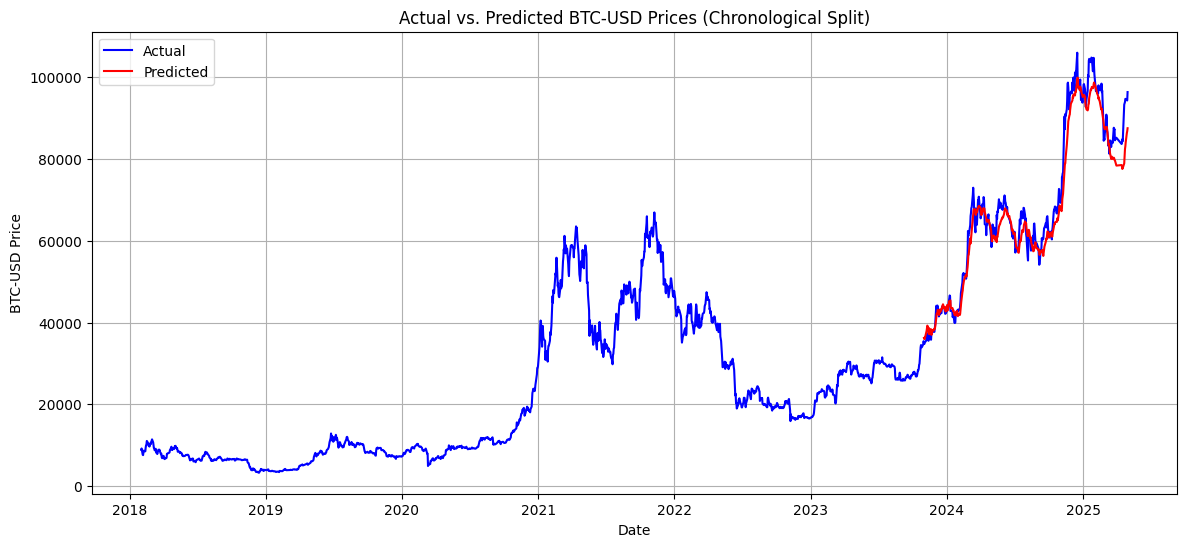

In [ ]:
# 6. Visualize the predictions on 20% of the observations (continuous data)

# Create a DataFrame for the predictions and actual values for the test set
og_data_test = pd.DataFrame({'Actual': y_test2, 'Predicted': y_pred2}, index=y_test2.index)


# Concatenate training and testing data for plotting
og_data_all = pd.concat([og_data2.iloc[:split_index][['BTC_Tomorrow']].rename(columns={'BTC_Tomorrow': 'Actual'}), og_data_test])


# Plot the data
plt.figure(figsize=(14, 6))
plt.plot(og_data_all.index, og_data_all['Actual'], label='Actual', color='blue')
plt.plot(og_data_test.index, og_data_test['Predicted'], label='Predicted', color='red')  # Plot predictions only for the test set

plt.xlabel('Date')
plt.ylabel('BTC-USD Price')
plt.title('Actual vs. Predicted BTC-USD Prices (Chronological Split)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 7. Price Prediction

# Forward fill missing values if we want to make predictions in the weekends (fill weekend NaN values with the Friday prices)
columns_to_fill = ['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']
og_data[columns_to_fill] = og_data[columns_to_fill].ffill()

# Get the latest available data (excluding BTC-USD_tomorrow)
latest_data = og_data.loc[og_data.index[-1], ['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']]

# Convert to DataFrame to retain column names
latest_data = pd.DataFrame([latest_data])

# Predict the next day's BTC price
next_day_prediction = model.predict(latest_data)

# Print the prediction
print(f"Predicted Bitcoin price for tomorrow: ${next_day_prediction[0]:,.2f}")

Predicted Bitcoin price for tomorrow: $95,620.19


Predicted Bitcoin price for tomorrow: $95,620.19


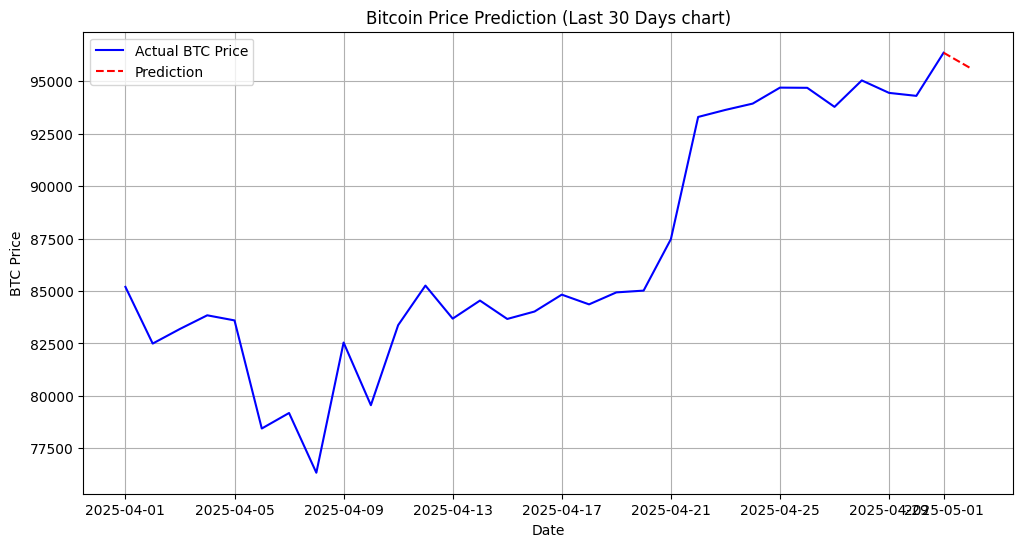

In [ ]:
8. # Visualize the prediction for the next day according to the latest data but closer look (Last 30 Days observation)

# Get the last known date and next predicted date
last_date = og_data.index[-1]
next_date = last_date + pd.Timedelta(days=1)

# Filter only the last 30 days
last_30 = og_data.loc[og_data.index >= last_date - pd.Timedelta(days=30)]

# Print the prediction and the range
print(f"Predicted Bitcoin price for tomorrow: ${next_day_prediction[0]:,.2f}")

# Plot actual BTC prices (last 30 days)
plt.figure(figsize=(12, 6))
plt.plot(last_30.index, last_30['BTC'], label="Actual BTC Price", color="blue", linestyle='-')

# Plot dotted line from last actual price to predicted price
plt.plot([last_date, next_date], [og_data['BTC'].iloc[-1], next_day_prediction[0]], 'r--', label="Prediction")

# Labels and title
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Bitcoin Price Prediction (Last 30 Days chart)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()